<a href="https://colab.research.google.com/github/chacha715/ESAA_OB/blob/main/%EA%B3%BC%EC%A0%9C_0327_%EC%95%99%EC%83%81%EB%B8%94_%EC%BA%90%EA%B8%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling/notebook

# **Titanic Top 4% with ensemble modeling**

> 목차
> 1. Introduction
> 2. Load and check data
> 3. Feature analysis
> 4. Filling missing Values
> 5. Feature engineering
> 6. Modeling

## **1. Introduction**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

## **2. Load and check data**

### **2.1 Load data**

In [2]:
from google.colab import drive
drive.mount("/content/drive")

# 경로 이동
%cd /content/drive/MyDrive/ESAA/23-1/DATA/0327

Mounted at /content/drive
/content/drive/MyDrive/ESAA/23-1/DATA/0327


In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
IDtest = test["PassengerId"]

### **2.2 Outlier detection**

- 이상치는 예측에 영향을 주므로 처리 필요
- *Turkey method* 사용

- 10개의 outlier 존재.
- 28, 89, 342 passenger -> high Ticket Fare
- 나머지 7명 -> high values of SibSP

In [4]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

In [5]:
# 이상치 확인
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [6]:
# 이상치 제거
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

### **2.3 joining tran and test set**

In [7]:
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

### **2.4 check for null and missing values**

- `Survived` -> test 데이터 때문
- `Age` , `Cabin`

In [8]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [9]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [10]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [12]:
# Summarize data
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## **3. Feature analysis**

### **3.1 Numerical values**

- `Fare`: 0.26
- 다른 변수는 not usefull
- Subpopulations in these features can be correlated with the survival.

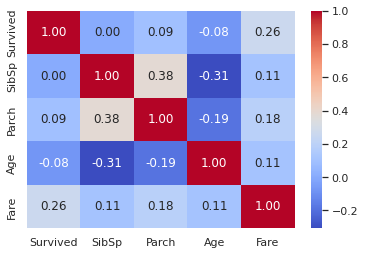

In [13]:
# Correlation matrix (numeric 변수 & survived)
g = sns.heatmap(train[["Survived", "SibSp", "Parch", "Age", "Fare"]].corr(),
                annot=True, fmt=".2f", cmap="coolwarm")

#### SibSP

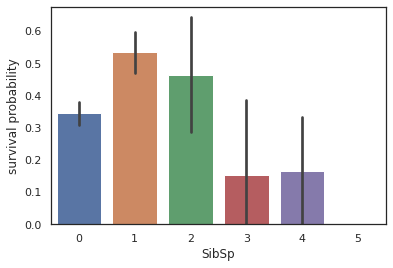

In [14]:
g = sns.barplot(x="SibSp",y="Survived",data=train)
g = g.set(ylabel="survival probability")

#### Parch

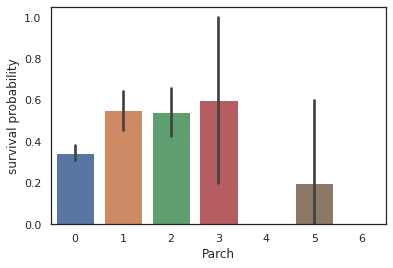

In [15]:
g = sns.barplot(x="Parch", y="Survived", data=train)
g = g.set(ylabel="survival probability")

#### Age

/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)


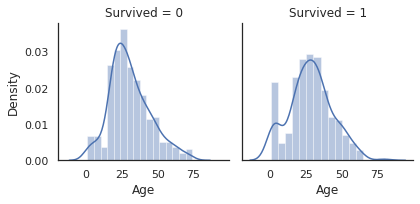

In [16]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

- 어린 승객 -> 봉우리 -> survived

<ipython-input-17-bdd81f2d955a>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())],
<ipython-input-17-bdd81f2d955a>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())],


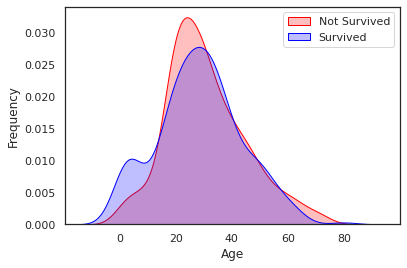

In [17]:
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())],
                color="Red", shade=True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())],
                ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived", "Survived"])

- 매우 어린 아이(0~5세)에 봉우리

#### Fare

In [18]:
dataset["Fare"].isnull().sum()

1

In [19]:
# 중앙값으로 결측치 채우기
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

<ipython-input-20-84a0b3e9fc6f>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))


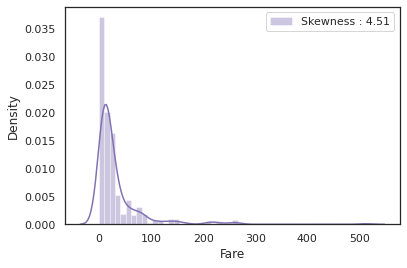

In [20]:
# 분포 확인
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

- 매우 skewed됨 -> **로그 변환** 필요

In [21]:
# 로그 변환
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

<ipython-input-22-35ec8efd2ddc>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))


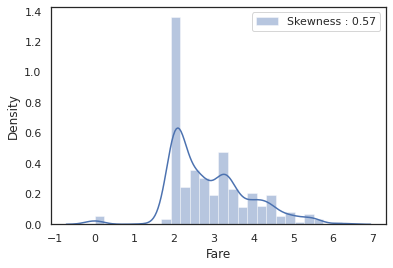

In [22]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

- 로그 변환 후 skewness 감소

### **3.2 Categorical values**

#### Sex

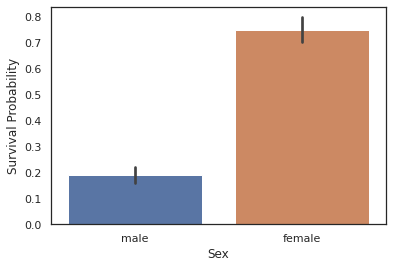

In [23]:
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

In [24]:
train[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


- 여성의 생존율이 높음
- `Sex`는 예측에 중요한 변수

#### Pclass

Text(0, 0.5, 'survival probability')

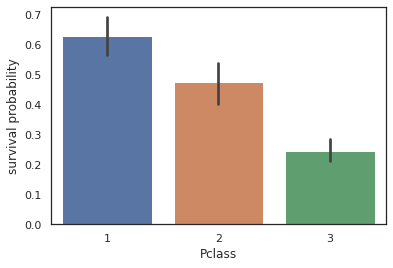

In [25]:
g = sns.barplot(x="Pclass", y="Survived", data=train)
g.set_ylabel("survival probability")

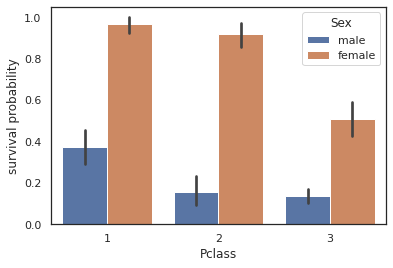

In [26]:
# Pclass vs Survived by Sex
g = sns.barplot(x="Pclass", y="Survived", hue="Sex", data=train)
g = g.set_ylabel("survival probability")

- 1st 클래스가 생존율 더 높음
- 성별에 따라 비교해봐도 동일

#### Embarked

In [27]:
dataset["Embarked"].isnull().sum()

2

In [28]:
dataset["Embarked"].value_counts()

S    904
C    270
Q    123
Name: Embarked, dtype: int64

In [29]:
# 최빈값으로 결측치 채우기
dataset["Embarked"] = dataset["Embarked"].fillna("S")

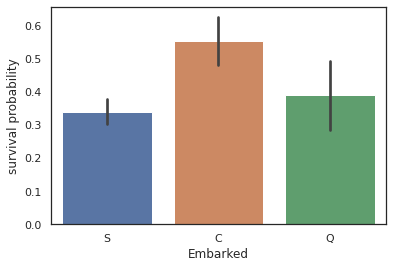

In [30]:
g = sns.barplot(x="Embarked", y='Survived', data=train)
g = g.set_ylabel("survival probability")

- Cherbourg(C)가 생존율 높음
- maybe... 생존율 높은 1st 클래스 승객 중 많은 수가 Cherbourg에서 왔기 때문?

/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:712: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


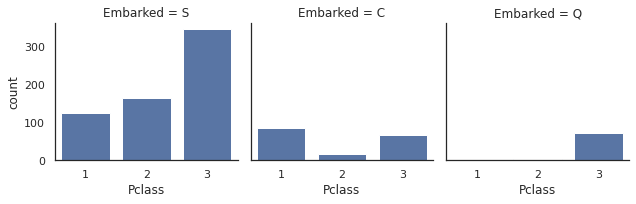

In [31]:
# Pclass vs Embarked
g = sns.FacetGrid(train, col='Embarked')
g = g.map(sns.countplot, "Pclass")

- 3rd 클래스 승객은 대부분 Queenstown(Q)에서 왔음
- Cherbourg(C)에서 온 승객은 1st 클래스가 가장 많음

## **4. Filling missing Values**

### **4.1 Age**

- `Age`에는 총 256개의 결측값이 존재
- 생존과 나이는 중요한 관계에 있기 때문에 결측값을 잘 채워야 함.
- 나이와 연관 높은 변수(Sex, Parch, Pclass, SibSP)를 살펴보자

- 성별에 따른 차이 없음 -> not informative
- 1st 클래스가 더 나이 많음
- parents/children 많으면 더 나이 많음
- siblings/spouses 많으면 비교적 젊음

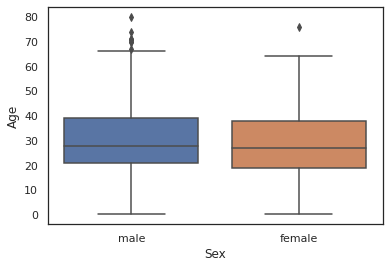

In [32]:
g = sns.boxplot(y="Age",x="Sex",data=dataset)

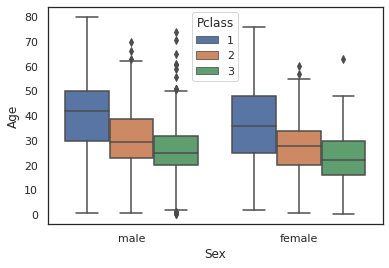

In [33]:
g = sns.boxplot(y="Age",x="Sex",hue="Pclass", data=dataset)

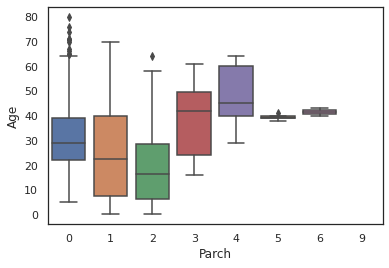

In [34]:
g = sns.boxplot(y="Age",x="Parch", data=dataset)

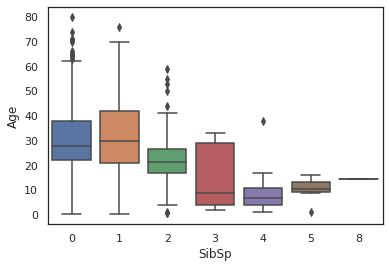

In [35]:
g = sns.boxplot(y="Age",x="SibSp", data=dataset)

In [36]:
# Sex: 0->male, 1->female
dataset["Sex"] = dataset["Sex"].map({"male":0, "female":1})

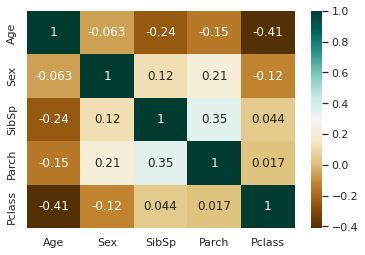

In [37]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

- 나이는 성별과는 상관관계 없음
- Pclass, Parch, SibSp와는 음의 상관관계 존재 -> Age의 결측치 채우는데 활용
- Parch는 barplot에서 Parch가 많으면 나이가 많은 것으로 보였지만 실제로는 음의 상관관계로 나옴

- **The strategy is to fill Age with the median age of similar rows according to Pclass, Parch and SibSp.**

In [38]:
# Age 결측치 채우기

index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
  age_med = dataset["Age"].median()
  age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()

  if not np.isnan(age_pred) :
    dataset['Age'].iloc[i] = age_pred
  else:
    dataset['Age'].iloc[i] = age_med

<ipython-input-38-aa3560dab318>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
<ipython-input-38-aa3560dab318>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
<ipython-input-38-aa3560dab318>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
<ipython-input-38-aa3560dab318>:10: SettingWithCopyWarning: 
A value is trying to be set on

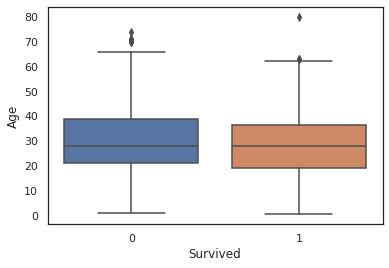

In [39]:
g = sns.boxplot(x="Survived", y = "Age",data = train)

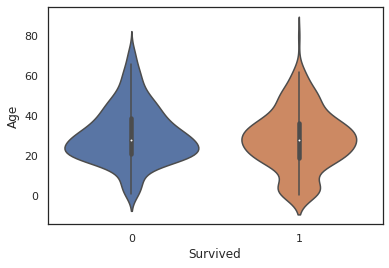

In [40]:
g = sns.violinplot(x="Survived", y = "Age",data = train)

## **5. Feature engineering**

### **5.1 Name/Title**

In [41]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [42]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

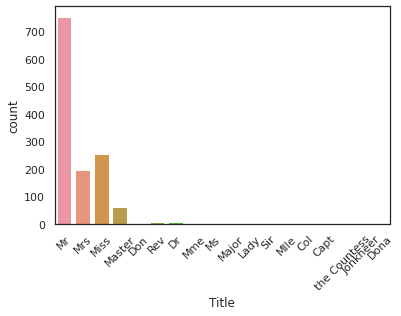

In [43]:
g = sns.countplot(x="Title", data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

In [44]:
# Convert to categorical values Title
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

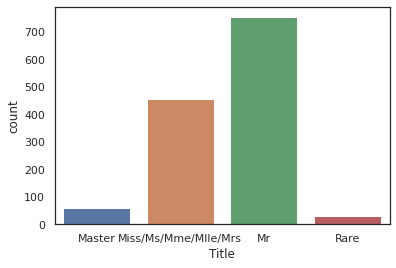

In [45]:
g = sns.countplot(x="Title", data=dataset)
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

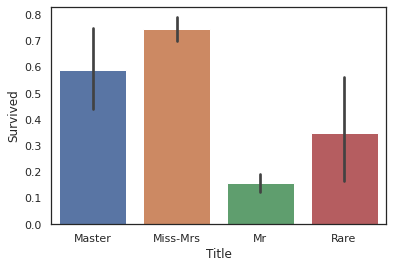

In [46]:
# y축은 생존율
g = sns.barplot(x="Title", y="Survived", data=dataset)
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])

- Women and children first
- Rare도 의외로 높은 생존율

In [47]:
# 이름 변수 제거
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

### **5.2 Family size**

In [48]:
# 가족수 변수 생성
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

/usr/local/lib/python3.9/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.9/dist-packages/numpy/lib/nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


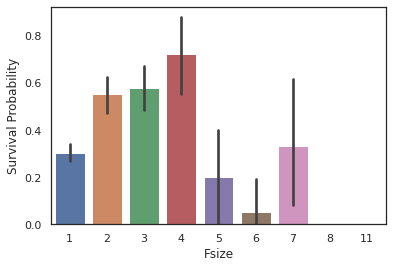

In [49]:
g = sns.barplot(x="Fsize",y="Survived",data=dataset)
g = g.set_ylabel("Survival Probability")

- 가족수가 많은 그룹의 생존율을 보면 매우 낮음

In [50]:
# 가족수 카테고리 나누기
dataset['Single'] = dataset['Fsize'].map(lambda s:1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

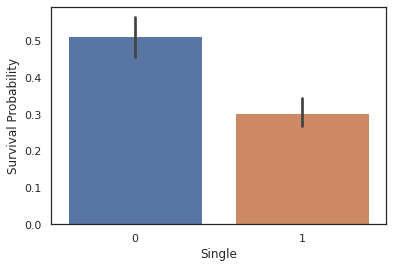

In [51]:
g = sns.barplot(x="Single",y="Survived",data=dataset)
g = g.set_ylabel("Survival Probability")

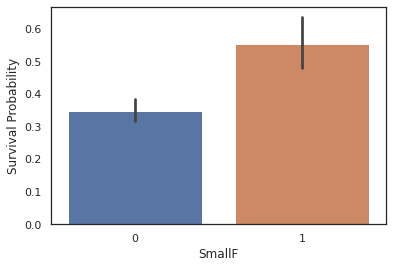

In [52]:
g = sns.barplot(x="SmallF",y="Survived",data=dataset)
g = g.set_ylabel("Survival Probability")

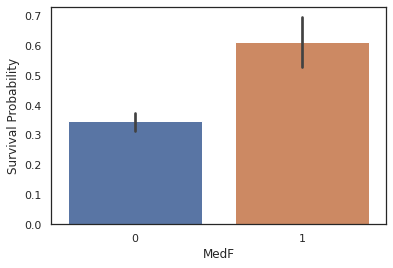

In [53]:
g = sns.barplot(x="MedF",y="Survived",data=dataset)
g = g.set_ylabel("Survival Probability")

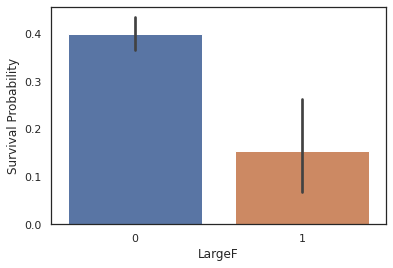

In [54]:
g = sns.barplot(x="LargeF",y="Survived",data=dataset)
g = g.set_ylabel("Survival Probability")

- Small & Medium 가족일 때 생존율 높게 나옴
- Single & Large 가족일 땐 생존율 낮게 나옴

In [55]:
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"],prefix="Em")

In [56]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


### **5.3 Cabin**

In [57]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [58]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [59]:
dataset["Cabin"].isnull().sum()

1007

In [60]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [61]:
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

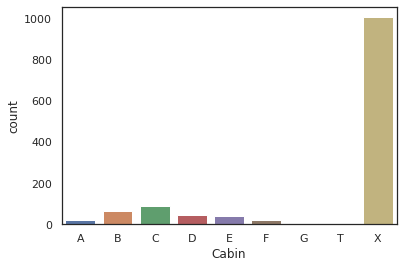

In [62]:
g = sns.countplot(x="Cabin",data=dataset, order=['A','B','C','D','E','F','G','T','X'])

- Cabin의 앞 글자는 Desk를 나타냄으로 승객의 위치와 관련됨

/usr/local/lib/python3.9/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


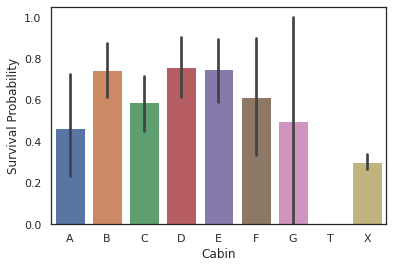

In [63]:
g = sns.barplot(y="Survived",x="Cabin",data=dataset,order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabel("Survival Probability")

- Cabin(desk)에 따른 생존율을 비교하기는 어렵지만 Cabin이 있고 없고(X)에 따른 생존율은 차이가 있음
- Cabin이 없는 그룹(X)은 낮은 생존율을 보임

In [64]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

### **5.4 Ticket**

In [65]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [66]:
# 접두사로 구분

Ticket = []
for i in list(dataset.Ticket):
  if not i.isdigit():
    Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) # 접두사만 가져오기
  else:
    Ticket.append("X")

dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [67]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [68]:
# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [69]:
# 필요없는 변수 제거
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [70]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


## **6. MODELING**

In [71]:
# train/test split

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"], axis=1, inplace=True)

<ipython-input-71-e754803d7f77>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(labels=["Survived"], axis=1, inplace=True)


In [72]:
train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"], axis=1)

<ipython-input-72-c3a1797c02ae>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Survived"] = train["Survived"].astype(int)


## **6.1 Simple modeling**

### **6.1.1 Cross validate models**

- SVC
- Decision Tree
- AdaBoost
- Random Forest
- Extra Trees
- Gradient Boosting
- Multiple layer perceprton (neural network)
- KNN
- Logistic regression
- Linear Discriminant Analysis

In [73]:
kfold = StratifiedKFold(n_splits=10)

In [74]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, Y_train, scoring = "accuracy", cv = kfold))

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

In [75]:
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

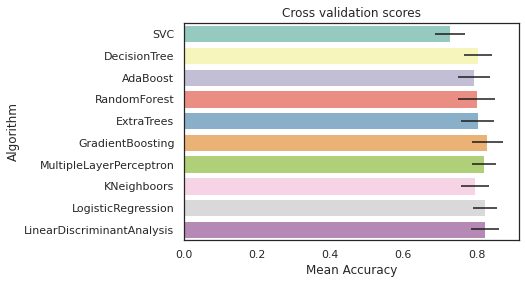

In [76]:
g = sns.barplot(x="CrossValMeans",y="Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

### **6.1.2 Hyperparameter tunning for best models**

In [77]:
# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:905: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  clone(base_estimator).set_params(**self.best_params_)


In [78]:
gsadaDTC.best_score_

0.8275536261491316

In [79]:
# ExtraTrees
ExtC = ExtraTreesClassifier()

# Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
                 "max_features": [1,3,10],
                 "min_samples_split": [2,3,10],
                 "min_samples_leaf": [1,3,10],
                 "bootstrap": [False],
                 "n_estimators": [100,300],
                 "criterion": ["gini"]}

gsExtC = GridSearchCV(ExtC, param_grid=ex_param_grid, cv=kfold,
                      scoring="accuracy", n_jobs=-1, verbose=1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.831996935648621

In [80]:
# RFC Parameters tunning
RFC = RandomForestClassifier()

# Search grid for optimal parametrs
rf_param_grid = {"max_depth": [None],
                 "max_features": [1,3,10],
                 "min_samples_split": [2,3,10],
                 "min_samples_leaf": [1,3,10],
                 "bootstrap": [False],
                 "n_estimators": [100,300],
                 "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC, param_grid=rf_param_grid, cv=kfold,
                     scoring="accuracy", n_jobs=-1, verbose=1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8342951991828397

In [81]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
                 'n_estimators' : [100,200,300],
                 'learning_rate' : [0.1, 0.05, 0.01],
                 'max_depth' : [4,8],
                 'min_samples_leaf' : [100,150],
                 'max_features' : [0.3, 0.1]}

gsGBC = GridSearchCV(GBC, param_grid=gb_param_grid, cv=kfold,
                     scoring="accuracy", n_jobs=-1, verbose=1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


0.833158835546476

In [82]:
# SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold,
                      scoring="accuracy", n_jobs= -1, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8331332992849847

### **6.1.3 Plot learning curves**

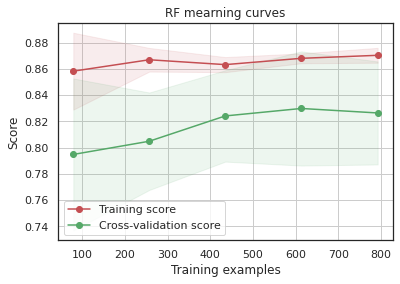

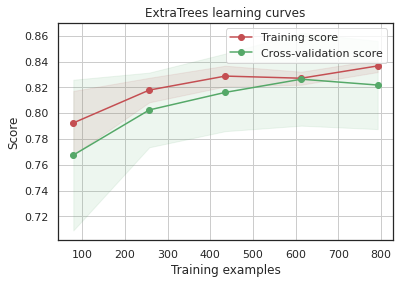

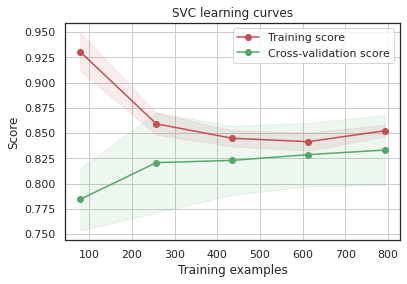

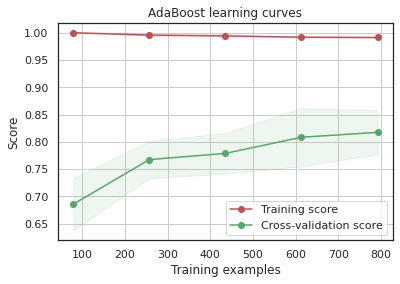

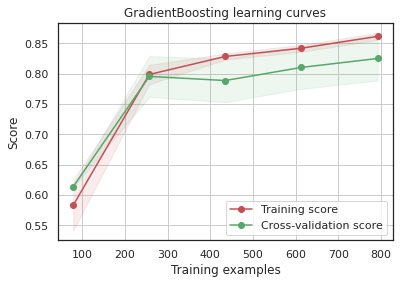

In [83]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)


- GradientBoosting과 Adaboost classifiers는 학습 데이터에 과적합됨.


### **6.1.4 Feature importance of trees based classifiers**

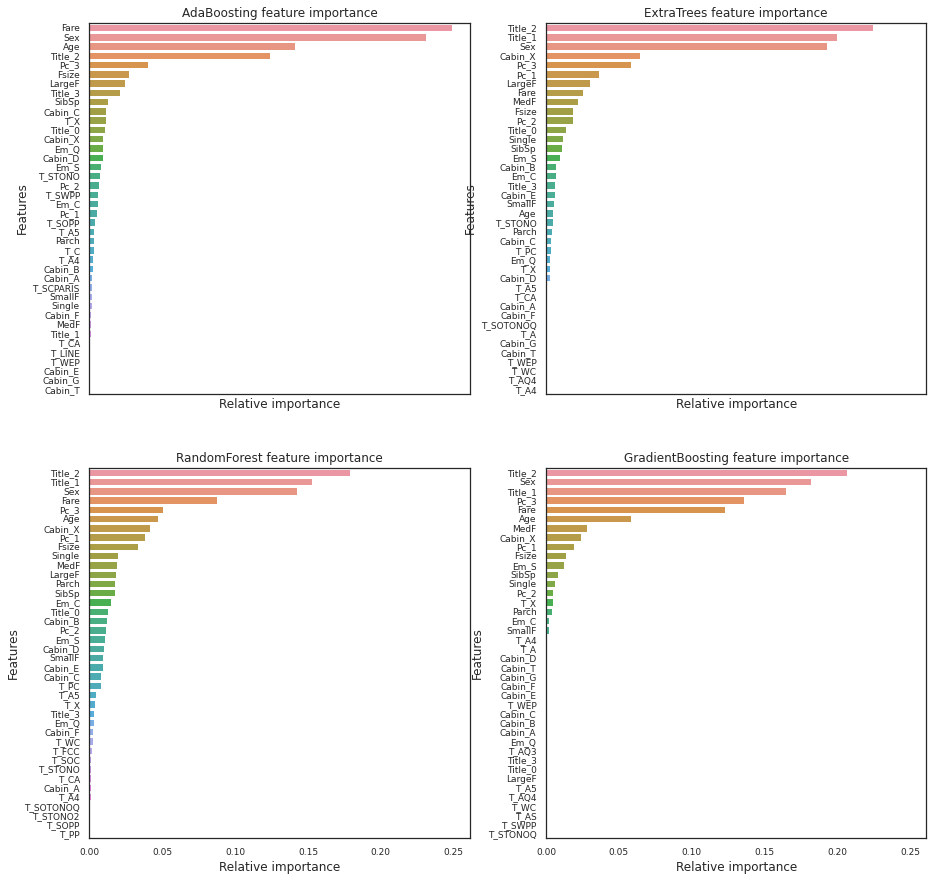

In [84]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
  for col in range(ncols):
    name = names_classifiers[nclassifier][0]
    classifier = names_classifiers[nclassifier][1]
    indices = np.argsort(classifier.feature_importances_)[::-1][:40]
    g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
    g.set_xlabel("Relative importance",fontsize=12)
    g.set_ylabel("Features",fontsize=12)
    g.tick_params(labelsize=9)
    g.set_title(name + " feature importance")
    nclassifier += 1

- 분류기마다 중요 변수가 다르지만 그나마 공통적인 변수들은 'Fare', 'Title_2', 'Age', 'Sex'.
- 'Title_2' 변수는 'Sex'와 상관관계가 높음



- Pc_1, Pc_2, Pc_3 and Fare refer to the general social standing of passengers.

- Sex and Title_2 (Mrs/Mlle/Mme/Miss/Ms) and Title_3 (Mr) refer to the gender.

- Age and Title_1 (Master) refer to the age of passengers.

- Fsize, LargeF, MedF, Single refer to the size of the passenger family.

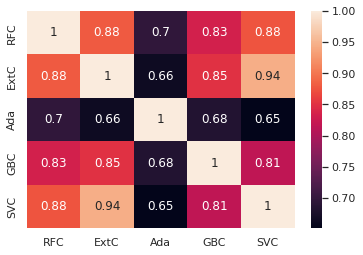

In [85]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")

# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)

g = sns.heatmap(ensemble_results.corr(),annot=True)

## **6.2 Ensemble modeling**

### **6.2.1 Combining models**

In [86]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=-1)

votingC = votingC.fit(X_train, Y_train)

## **6.3 Prediction**

### **6.3.1 Predict and Submit results**

In [87]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest, test_Survived], axis=1)

# results.to_csv("ensemble_python_voting.csv",index=False)